In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score
import pandas as pd

# Load data

In [3]:
# Prepare lists to store images and their corresponding labels
images = []
labels = []

# Loop over each subfolder
for folder_name in folders:
    folder_path = os.path.join(data_path, folder_name)
    
    # Loop over each file in the subfolder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        
        # Check if the file is an image (by extension)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # Read the image using OpenCV
            img = cv2.imread(file_path)
            
            # Optionally, convert BGR (OpenCV default) to RGB
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Append the image and label to their respective lists
            images.append(img)
            labels.append(folder_name)

# Now, `images` contains all the loaded images,
# and `labels` contains the corresponding folder names.
print(f"Total images loaded: {len(images)}")
print(f"Unique labels: {set(labels)}")

Total images loaded: 2138
Unique labels: {'4', '1', '0', '2', '5', '3'}


In [2]:
import os
import cv2  # Make sure you have OpenCV installed: pip install opencv-python

# Define the path to the main data folder
data_path = '/kaggle/input/pineapple-ripeness-classification/train/train'

# List all subfolders in the main folder
folders = [f for f in os.listdir(data_path) 
           if os.path.isdir(os.path.join(data_path, f))]
print(folders)



['2', '5', '0', '3', '1', '4']


# Train val split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    images, 
    labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

print("Total images:", len(images))
print("Training set size:", len(X_train))
print("val set size:", len(X_val))
print("Unique classes:", set(labels))

Total images: 2138
Training set size: 1710
val set size: 428
Unique classes: {'4', '1', '0', '2', '5', '3'}


# Check size of img

In [5]:
images[0].shape

(128, 128, 3)

# Create Dataset/ Dataloader

In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: list or array of image arrays (NumPy)
        labels: list or array of label strings
        transform: torchvision transforms (optional)
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        # Map label names to integer indices
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label_str = self.labels[idx]
        label_idx = self.label_to_idx[label_str]

        pil_img = Image.fromarray(img[..., ::-1])  # BGR->RGB while creating PIL image

        if self.transform:
            pil_img = self.transform(pil_img)

        return pil_img, label_idx


In [7]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create Dataset objects
train_dataset = CustomImageDataset(X_train, y_train, transform=train_transform)
val_dataset  = CustomImageDataset(X_val,  y_val,  transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=16, shuffle=False)


# Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


model = models.efficientnet_v2_s(weights='DEFAULT')  

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6) # pineapple 6 classes
#softmax = nn.Softmax(dim=1) --> to change to prob
model = model.to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 217MB/s]


# Train

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # adjust as needed
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,  # Peak LR
    steps_per_epoch=len(train_loader),  # Number of batches per epoch
    epochs=num_epochs,  # Total epochs
)

In [10]:
best_val_loss = float('inf')
best_f1 = float('-inf')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    #################
    #  TRAIN PHASE  #
    #################
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images_batch.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels_batch).sum().item()
        total += labels_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    # Store train loss & accuracy
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    
    ###############
    #  VAL PHASE  #
    ###############
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Lists to accumulate predictions & labels for F1 calculation
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)

            val_loss += loss.item() * images_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels_batch).sum().item()
            val_total += labels_batch.size(0)
            
            # Collect predictions and labels for F1
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    val_loss_epoch = val_loss / val_total
    val_acc = val_correct / val_total

    # Store val loss & accuracy
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc)
    
    # Compute F1 (macro)
    f1_macro = f1_score(all_labels, all_preds, average='macro')



    print(f"           val Loss: {val_loss_epoch:.4f} | "
          f"val Acc: {val_acc:.4f} | "
          f"F1 Macro: {f1_macro:.4f}")
    # Save the best model based on val loss
    if f1_macro > best_f1:
        best_f1 = f1_macro
        print('save')
        torch.save(model.state_dict(), 'best_pine_class_efficientv2_L.pth')

# ---- End of Training Loop ----

Epoch [1/100] - Train Loss: 0.5270 | Train Acc: 0.8187
           val Loss: 0.3349 | val Acc: 0.8879 | F1 Macro: 0.4232
save
Epoch [2/100] - Train Loss: 0.3652 | Train Acc: 0.8690
           val Loss: 0.3929 | val Acc: 0.8551 | F1 Macro: 0.3397
Epoch [3/100] - Train Loss: 0.2568 | Train Acc: 0.9076
           val Loss: 0.3616 | val Acc: 0.8879 | F1 Macro: 0.5226
save
Epoch [4/100] - Train Loss: 0.2141 | Train Acc: 0.9193
           val Loss: 0.2628 | val Acc: 0.9136 | F1 Macro: 0.5861
save
Epoch [5/100] - Train Loss: 0.1820 | Train Acc: 0.9351
           val Loss: 0.2384 | val Acc: 0.9299 | F1 Macro: 0.6985
save
Epoch [6/100] - Train Loss: 0.1477 | Train Acc: 0.9538
           val Loss: 0.2500 | val Acc: 0.9276 | F1 Macro: 0.7059
save
Epoch [7/100] - Train Loss: 0.1674 | Train Acc: 0.9363
           val Loss: 0.2471 | val Acc: 0.9065 | F1 Macro: 0.6903
Epoch [8/100] - Train Loss: 0.0969 | Train Acc: 0.9602
           val Loss: 0.2875 | val Acc: 0.9276 | F1 Macro: 0.6484
Epoch [9/100] -

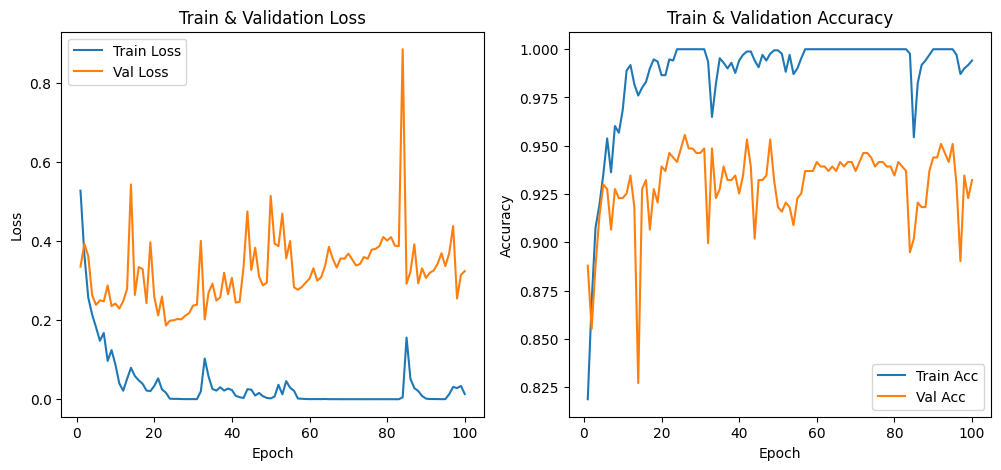

In [11]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Train & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.title('Train & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test

In [23]:
test_path = '/kaggle/input/pineapple-ripeness-classification/test/test'

# List all subfolders in the main folder
file_paths = [f for f in os.listdir(test_path)]


In [ ]:
# Prepare lists to store images and their corresponding labels
images_test = []
file_name_test = []

labels_test = [0]*535 #pseudo label
    
# Loop over each file in the subfolder
for file_name in file_paths:
    file_path = os.path.join(test_path, file_name)
    file_name_test.append(file_name)
    # Check if the file is an image (by extension)
    if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Read the image using OpenCV
        img = cv2.imread(file_path)

        
        # have to convert BGR (OpenCV default) to RGB
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Append the image and label to their respective lists
        images_test.append(img)

# Now, `images` contains all the loaded images,
# and `labels` contains the corresponding folder names.
print(f"Total images loaded: {len(images_test)}")
print(f"Unique labels: {set(labels_test)}")

Total images loaded: 535
Unique labels: {0}


In [25]:
len(labels_test)

535

In [26]:
model = models.efficientnet_v2_s(pretrained=False)
model.classifier[1] = nn.Linear(num_features, 6)
model.to(device)


# 2) Load the saved "best" weights from the training phase
model.load_state_dict(torch.load('/kaggle/working/best_pine_class.pth'))

<ipython-input-26-1f6a6dc21ab4>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_pine_class.pth'))


<All keys matched successfully>

In [27]:
test_dataset  = CustomImageDataset(images_test,  labels_test,  transform=val_transform)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

In [28]:
len(test_loader)
len(labels_test)

535

In [29]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        # Forward pass
        outputs = model(images_batch)
        
        # Compute test loss
        loss = criterion(outputs, labels_batch)
        test_loss += loss.item() * images_batch.size(0)
        
        # Predictions
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels_batch).sum().item()
        test_total += labels_batch.size(0)

        # Collect for metrics and CSV
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

# Final test metrics
test_loss_epoch = test_loss / test_total
test_acc = test_correct / test_total
test_f1_macro = f1_score(all_labels, all_preds, average='macro')

print(f"Test Loss: {test_loss_epoch:.4f} | "
      f"Test Acc: {test_acc:.4f} | "
      f"F1 Macro: {test_f1_macro:.4f}")

#  Save predictions to CSV
df = pd.DataFrame({'FileName': file_name_test, 
                   'Class': all_preds})
df.to_csv('test_predictions.csv', index=False)

print("Predictions saved to test_predictions.csv")

Test Loss: 2.0730 | Test Acc: 0.7664 | F1 Macro: 0.1446
Predictions saved to test_predictions.csv


# Remark
> Test Loss: 2.0730 | Test Acc: 0.7664 | F1 Macro: 0.1446 are not necessary because it calculate from my assumption that all test dataset is in class 0 (You can see its in code cell 24)